# Figures for Mapping GHG emissions paper

In [15]:
import itertools
import wbdata
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

colors = ['#fc8d59', '#4575b4',  '#d73027', '#91bfdb', '#191922']+['pink', 'green', 'brown']+['#d3d3d3']

colors_used = colors[:-1]

color_dict = {'China':colors[0], 'USA':colors[1], 'South Korea':colors[2], 'India':colors[3], 'Russia':colors[4], 'Saudi Arabia':colors[5], 'Taiwan':colors[6], 'Germany':colors[7], 'Rest of World':colors[8], 'Netherlands': colors[8], 'Poland':colors[8]}

def filter_df(df, cols, filters):
    for col, filt in zip(cols, filters):
        df = df[[i in filt for i in df[col]]]
    return df

output_path = '/figures/'

In [21]:
# Load data
path = '/data/'
data = pd.read_parquet(path+'combined/240411_All/facilityEmissions_all.parquet')

In [22]:
years = [str(i) for i in range(1978, 2051)]
years_sigma = [year+'_sigma' for year in years]
data_filt = data[['Product type', 'Product group', 'Gas', 'Region', 'COUNTRY/TERRITORY', 'Type']+years+ years_sigma]
data_filt = data_filt.groupby(['Product type', 'Product group', 'Gas', 'Region', 'COUNTRY/TERRITORY', 'Type']).sum().reset_index()

data_filt['Product group'] = data_filt['Product group'].replace({'Thermosets, fibre & elastomers':'Thermosets, fibres\n& elastomers', 'Solvents, additives & explosives': 'Solvents, additives\n& explosives'})
data_filt['Type'] = data_filt['Type'].replace({'Direct Utilities':'Direct Energy Use', 'Indirect Utilities': 'Indirect Energy Use'})

data_with_elec = data_filt[[i not in ['EI & CM', 'IHS CtOG'] for i in data_filt['Type']]]
data_filt = data_filt[[i not in ['EI & CM', 'Electricity', 'IHS CtOG'] for i in data_filt['Type']]]

year_used = '2020'
counting_types = ['Direct Process', 'Indirect Energy Use', 'Direct Energy Use', 'Feedstock']
scale_factor = 1E3

In [23]:
primary_ems = filter_df(data_filt, ['Gas', 'Product group'],[['CO2e_100a'], ['Primary chemicals']])
primary_ems = primary_ems[primary_ems['Type']!='Primary chemicals']
               
primary_ems = primary_ems.groupby(['COUNTRY/TERRITORY']).sum().reset_index().sort_values(year_used, ascending=False)
primary_ems = primary_ems[['COUNTRY/TERRITORY']+ years+years_sigma]
primary_ems.set_index('COUNTRY/TERRITORY', inplace=True)

In [24]:
intermediate_ems = filter_df(data_filt, ['Gas', 'Product group'],[['CO2e_100a'], ['Intermediates']])
intermediate_ems = intermediate_ems[intermediate_ems['Type']!='Intermediates']
               
intermediate_ems = intermediate_ems.groupby(['COUNTRY/TERRITORY']).sum().reset_index().sort_values(year_used, ascending=False)
intermediate_ems = intermediate_ems[['COUNTRY/TERRITORY']+ years+years_sigma]
intermediate_ems.set_index('COUNTRY/TERRITORY', inplace=True)

fertiliser_ems = filter_df(data_filt, ['Gas', 'Product group'],[['CO2e_100a'], ['N-fertilisers']])
      
fertiliser_ems = fertiliser_ems.groupby(['COUNTRY/TERRITORY']).sum().reset_index().sort_values(year_used, ascending=False)
fertiliser_ems = fertiliser_ems[['COUNTRY/TERRITORY']+ years+years_sigma]
fertiliser_ems.set_index('COUNTRY/TERRITORY', inplace=True)

platic_ems = filter_df(data_filt, ['Gas', 'Product group'],[['CO2e_100a'], ['Thermoplastics']])
      
platic_ems = platic_ems.groupby(['COUNTRY/TERRITORY']).sum().reset_index().sort_values(year_used, ascending=False)
platic_ems = platic_ems[['COUNTRY/TERRITORY']+ years+years_sigma]
platic_ems.set_index('COUNTRY/TERRITORY', inplace=True)

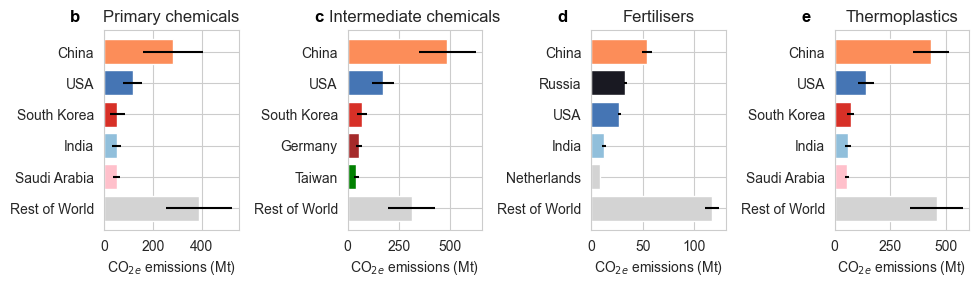

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 4, figsize=(10, 3))

scale_factor = 1E3
# Selecting top 5 countries based on emissions

def plot_hbars(ax, df, title, letter):
    top_5 = df.nlargest(5, "2020").copy()
    # Summing the rest of the world's emissions and uncertainties
    rest_of_world = df.iloc[5:].sum()
    rest_of_world.name = "Rest of World"
    top_5_with_rest = pd.concat((top_5, pd.DataFrame(rest_of_world).transpose())).iloc[::-1]
    
    bar_colors = top_5_with_rest.reset_index()['index'].map(color_dict)

    # Plotting
    ax.barh(top_5_with_rest.index, top_5_with_rest["2020"]/scale_factor, xerr=top_5_with_rest["2020_sigma"]/scale_factor, color=bar_colors)
    ax.set_xlabel('CO$_{2e}$ emissions (Mt)')
    ax.set_title(title)
    ax.text(-0.25, 1.1, letter, transform = ax.transAxes, fontsize=12, fontweight = 'bold', color = 'black', va='top', ha='left', **{'fontname':'Arial'})
    
plot_hbars(axs[0], primary_ems, 'Primary chemicals', 'b')
plot_hbars(axs[1], intermediate_ems, 'Intermediate chemicals', 'c')
plot_hbars(axs[2], fertiliser_ems, 'Fertilisers', 'd')
plot_hbars(axs[3], platic_ems, 'Thermoplastics', 'e')
    
fig.tight_layout()
# top_5 = primary_ems.nlargest(5, "2020").copy()
# # Summing the rest of the world's emissions and uncertainties
# rest_of_world = primary_ems.iloc[5:].sum()
# rest_of_world.name = "Rest of World"
# top_5_with_rest = pd.concat((top_5, pd.DataFrame(rest_of_world).transpose())).iloc[::-1]
# 
# # Plotting
# ax.barh(top_5_with_rest.index, top_5_with_rest["2020"]/scale_factor, xerr=top_5_with_rest["2020_sigma"]/scale_factor, color=colors[::-1])
# ax.set_xlabel('CO$_{2e}$ emissions (Mt)')
# ax.set_title("Primary chemicals")
# fig.tight_layout()

In [28]:
# Save output plot
fig.savefig(output_path+'Figure_3a.eps', format='eps', bbox_inches='tight',dpi=300)

# Save output plot
fig.savefig(output_path+'Figure_3a.png', format='png', bbox_inches='tight',dpi=300)